## Importing Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import tarfile

tar = tarfile.open('/content/drive/MyDrive/parallel.tgz', "r:gz")
tar.extractall()
tar.close()

In [ ]:
%cd parallel

/content/parallel


In [ ]:
import pandas as pd
import numpy as np

from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, RepeatVector
from keras.preprocessing.text import Tokenizer
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.sequence import pad_sequences
from keras.models import load_model
from tensorflow.keras import optimizers
from tensorflow.keras.utils import to_categorical
from keras.utils.vis_utils import plot_model

from sklearn.model_selection import train_test_split

from nltk.translate.bleu_score import corpus_bleu

In [ ]:
# dataframe
data = pd.DataFrame()

In [ ]:
with open('IITB.en-hi.en', encoding = 'utf8') as f:
    en_data = f.readlines()

In [ ]:
with open('IITB.en-hi.hi', encoding='utf-8') as f:
    hi_data = f.readlines()

In [ ]:
data['english'] = en_data
data['hindi'] = hi_data

In [ ]:
data.head()

,english,hindi
0,Give your application an accessibility workout\n,अपने अनुप्रयोग को पहुंचनीयता व्यायाम का लाभ दें\n
1,Accerciser Accessibility Explorer\n,एक्सेर्साइसर पहुंचनीयता अन्वेषक\n
2,The default plugin layout for the bottom panel\n,निचले पटल के लिए डिफोल्ट प्लग-इन खाका\n
3,The default plugin layout for the top panel\n,ऊपरी पटल के लिए डिफोल्ट प्लग-इन खाका\n
4,A list of plugins that are disabled by default\n,उन प्लग-इनों की सूची जिन्हें डिफोल्ट रूप से नि...


## Preprocessing Data

### Dealing with sentence outliers

In [ ]:
def sent_len(text):
    return len(text.split(' '))

In [ ]:
data['eng_sent_len'] = data.english.apply(lambda sent : sent_len(sent))
data['hi_sent_len'] = data.hindi.apply(lambda sent : sent_len(sent))

In [ ]:
data.head()

,english,hindi,eng_sent_len,hi_sent_len
0,Give your application an accessibility workout\n,अपने अनुप्रयोग को पहुंचनीयता व्यायाम का लाभ दें\n,6,8
1,Accerciser Accessibility Explorer\n,एक्सेर्साइसर पहुंचनीयता अन्वेषक\n,3,3
2,The default plugin layout for the bottom panel\n,निचले पटल के लिए डिफोल्ट प्लग-इन खाका\n,8,7
3,The default plugin layout for the top panel\n,ऊपरी पटल के लिए डिफोल्ट प्लग-इन खाका\n,8,7
4,A list of plugins that are disabled by default\n,उन प्लग-इनों की सूची जिन्हें डिफोल्ट रूप से नि...,9,12


In [ ]:
print(f'Maximum english sentence length : {max(data.eng_sent_len)}')
print(f'Maximum hindi sentence length : {max(data.hi_sent_len)}')

Maximum english sentence length : 1917
Maximum hindi sentence length : 1380


In [ ]:
print(f'Average English sentence length : {np.mean(data.eng_sent_len)}')
print(f'Average Hindi sentence length : {np.mean(data.hi_sent_len)}')

Average English sentence length : 12.92381725086073
Average Hindi sentence length : 14.38113428615093


In [ ]:
# new dataset
data = data[(data['eng_sent_len']<=30) & (data['hi_sent_len']<=30)].reset_index(drop=True)

In [ ]:
data.head()

,english,hindi,eng_sent_len,hi_sent_len
0,Give your application an accessibility workout\n,अपने अनुप्रयोग को पहुंचनीयता व्यायाम का लाभ दें\n,6,8
1,Accerciser Accessibility Explorer\n,एक्सेर्साइसर पहुंचनीयता अन्वेषक\n,3,3
2,The default plugin layout for the bottom panel\n,निचले पटल के लिए डिफोल्ट प्लग-इन खाका\n,8,7
3,The default plugin layout for the top panel\n,ऊपरी पटल के लिए डिफोल्ट प्लग-इन खाका\n,8,7
4,A list of plugins that are disabled by default\n,उन प्लग-इनों की सूची जिन्हें डिफोल्ट रूप से नि...,9,12


### Removing extra punctuations and unnecessary symbols

In [ ]:
def clean_text(text):
  text = text.lower()
  text = text.replace('\n', ' ')
  #text = '[START] '+ text + ' [END]'
  text = text.strip()
  return text

In [ ]:
data.english = data.english.apply(lambda sent : clean_text(sent))
data.hindi = data.hindi.apply(lambda sent : clean_text(sent))

In [ ]:
data.head()

,english,hindi,eng_sent_len,hi_sent_len
0,give your application an accessibility workout,अपने अनुप्रयोग को पहुंचनीयता व्यायाम का लाभ दें,6,8
1,accerciser accessibility explorer,एक्सेर्साइसर पहुंचनीयता अन्वेषक,3,3
2,the default plugin layout for the bottom panel,निचले पटल के लिए डिफोल्ट प्लग-इन खाका,8,7
3,the default plugin layout for the top panel,ऊपरी पटल के लिए डिफोल्ट प्लग-इन खाका,8,7
4,a list of plugins that are disabled by default,उन प्लग-इनों की सूची जिन्हें डिफोल्ट रूप से नि...,9,12


In [ ]:
data.shape

(1395167, 4)

In [ ]:
new_data = data[:10000]

## Text to Sequence Conversion

In [ ]:
# building a tokenizer
def tokenization(lines):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(lines)
    return tokenizer

In [ ]:
eng_tokenizer = tokenization(new_data.english)
eng_vocab_size = len(eng_tokenizer.word_index) + 1

hi_tokenizer = tokenization(new_data.hindi)
hi_vocab_size = len(hi_tokenizer.word_index) + 1

In [ ]:
print(f'English Vocabulary size : {eng_vocab_size}')
print(f'Hindi Vocabulary size : {hi_vocab_size}')

English Vocabulary size : 1523
Hindi Vocabulary size : 1959


In [ ]:
# encode and pad sequences, padding to maximum length of the sentences
def encode_sequences(tokenizer, length, lines):
  # integer encodeing of sequences
  seq = tokenizer.texts_to_sequences(lines)
  # pad sequences with 0 post values
  seq = pad_sequences(seq, maxlen = length, padding = 'post')
  return seq

In [ ]:
# one hot encode target sequence
def encode_output(sequences, vocab_size):
  ylist = list()
  for seq in sequences:
    encoded = to_categorical(seq, num_classes = vocab_size)
    ylist.append(encoded)
  y = np.array(ylist)
  y = y.reshape(sequences.shape[0], sequences.shape[1], vocab_size)
  return y

## Splitting of data into training and testing 

In [ ]:
train, test = train_test_split(new_data, test_size=0.3, random_state=35)

In [ ]:
trainX = encode_sequences(hi_tokenizer, 30, train.hindi)
trainy = encode_sequences(eng_tokenizer, 30, train.english)
trainy = encode_output(trainy, eng_vocab_size)

testX = encode_sequences(hi_tokenizer, 30, test.hindi)
testy = encode_sequences(eng_tokenizer, 30, test.english)
testy = encode_output(testy, eng_vocab_size)

## Defining Seq2Seq Model

In [ ]:
def define_model(input_vocab, output_vocab, input_timesteps, output_timesteps, n_units):
    # Encoding layers
    model = Sequential()
    model.add(Embedding(input_vocab, n_units, input_length = input_timesteps, mask_zero = True))
    model.add(LSTM(n_units))
    
    model.add(RepeatVector(output_timesteps))
    
    # Decoding Layers
    model.add(LSTM(n_units, return_sequences = True))
    model.add(Dense(output_vocab, activation = 'softmax'))
    
    return model

In [ ]:
# define model
model = define_model(hi_vocab_size, eng_vocab_size, 30, 30 , 256)
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy')

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 30, 256)           501504    
_________________________________________________________________
lstm (LSTM)                  (None, 256)               525312    
_________________________________________________________________
repeat_vector (RepeatVector) (None, 30, 256)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 30, 256)           525312    
_________________________________________________________________
dense (Dense)                (None, 30, 1523)          391411    
Total params: 1,943,539
Trainable params: 1,943,539
Non-trainable params: 0
_________________________________________________________________
None


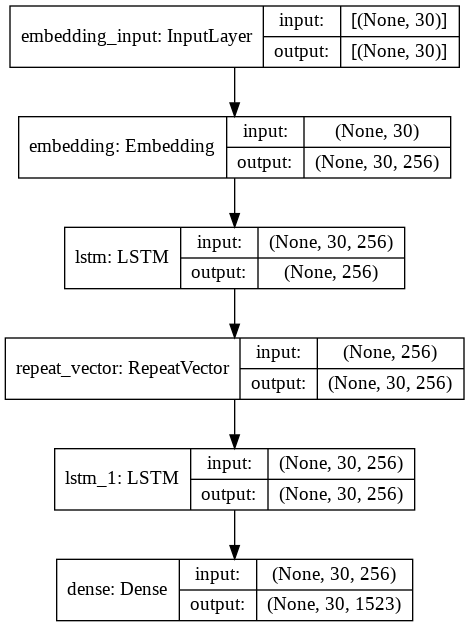

In [ ]:
# summarize defined model
print(model.summary())
plot_model(model, to_file = 'model.png', show_shapes = True)

In [ ]:
# fit model
filename = 'My_Translation_HI_EN_Model.h5'
checkpoint = ModelCheckpoint(filename, monitor = 'val_loss', verbose = 1, save_best_only = True, mode = 'min')
model.fit(trainX, trainy, epochs = 30, batch_size = 200, validation_data = (testX, testy), callbacks = [checkpoint], verbose = 2)

Epoch 1/30
35/35 - 14s - loss: 2.7307 - val_loss: 0.9514

Epoch 00001: val_loss improved from inf to 0.95137, saving model to My_Translation_HI_EN_Model.h5
Epoch 2/30
35/35 - 3s - loss: 0.9081 - val_loss: 0.8813

Epoch 00002: val_loss improved from 0.95137 to 0.88134, saving model to My_Translation_HI_EN_Model.h5
Epoch 3/30
35/35 - 3s - loss: 0.8158 - val_loss: 0.7621

Epoch 00003: val_loss improved from 0.88134 to 0.76206, saving model to My_Translation_HI_EN_Model.h5
Epoch 4/30
35/35 - 2s - loss: 0.7612 - val_loss: 0.7436

Epoch 00004: val_loss improved from 0.76206 to 0.74362, saving model to My_Translation_HI_EN_Model.h5
Epoch 5/30
35/35 - 3s - loss: 0.7509 - val_loss: 0.7463

Epoch 00005: val_loss did not improve from 0.74362
Epoch 6/30
35/35 - 2s - loss: 0.7468 - val_loss: 0.7769

Epoch 00006: val_loss did not improve from 0.74362
Epoch 7/30
35/35 - 3s - loss: 0.8099 - val_loss: 0.8331

Epoch 00007: val_loss did not improve from 0.74362
Epoch 8/30
35/35 - 3s - loss: 0.8045 - val_

## Predicting text

In [ ]:
translation = model.predict(testX[:10])

In [ ]:
translation

array([[[1.54010158e-05, 4.99894395e-02, 2.42984243e-04, ...,
         1.46267077e-04, 2.14893240e-04, 1.67450107e-05],
        [4.16989875e-04, 3.87149639e-02, 3.99547117e-03, ...,
         1.18469807e-05, 4.04136554e-05, 2.94923916e-06],
        [3.93045321e-02, 1.22464839e-02, 4.26721526e-03, ...,
         1.02990339e-06, 7.36154925e-06, 5.67295842e-07],
        ...,
        [9.99658704e-01, 3.50821301e-06, 9.94302172e-06, ...,
         2.23982139e-12, 4.35673025e-11, 7.24317915e-12],
        [9.99658704e-01, 3.50823962e-06, 9.94309812e-06, ...,
         2.23980860e-12, 4.35671360e-11, 7.24315182e-12],
        [9.99658704e-01, 3.50825303e-06, 9.94311722e-06, ...,
         2.23979559e-12, 4.35669729e-11, 7.24312407e-12]],

       [[8.48599069e-04, 7.75237102e-04, 6.89871740e-05, ...,
         9.11770330e-05, 1.37296389e-04, 3.32876843e-05],
        [9.32968616e-01, 1.47246701e-05, 4.75552770e-06, ...,
         3.54711247e-08, 1.98094284e-07, 3.20827951e-08],
        [9.98385906e-01, 

In [ ]:
def get_words(n, tokenizer):
  for word, index in tokenizer.word_index.items():
    if index == n:
      return word
  return None

In [ ]:
# generate target given source sequence
def predict_sequence(model, tokenizer, source):

  prediction = model.predict(source, verbose = 0)[0]
  integers = [np.argmax(vector) for vector in prediction]
  
  target = list()
  for i in integers:
    word = get_words(i, tokenizer)
    if word is None:
      break
    target.append(word)
  return ' '.join(target)

## Checking predictions

In [ ]:
def eval_model(model, tokenizer, sources, raw_dataset):
  actual, predicted = list(), list()
  tar=list(raw_dataset.english)
  src=list(raw_dataset.hindi)
  for i, source in enumerate(sources):
    # translate ecoded source text
    # print(i,type(i))
    source = source.reshape((1, source.shape[0]))
    translation = predict_sequence(model, tokenizer, source)
    # print(tar[:1])
    raw_target = tar[i]
    raw_src = src[i]
    # print(raw_target,'****',raw_src)
    if i<10:
      print('src=[%s], target=[%s], predicted=[%s]' % (raw_src, raw_target, translation))
      sss=str(raw_target)
      actual.append([sss.split()])
      predicted.append(translation.split())
  
  # dataframe
  df = pd.DataFrame({'actual' : actual, 'predicted' : predicted})
  df.head(10)
  # calculate BLEU score
  print('BLEU-1 : %f' % corpus_bleu(actual, predicted, weights = (1.0,0,0,0)))
  print('BLEU-2 : %f' % corpus_bleu(actual, predicted, weights = (0.5,0.5,0,0)))
  print('BLEU-3 : %f' % corpus_bleu(actual, predicted, weights = (0.3,0.3,0.3,0)))
  print('BLEU-4 : %f' % corpus_bleu(actual, predicted, weights = (0.25,0.25,0.25,0.25)))

In [ ]:
eval_model(model, eng_tokenizer, trainX, train)

src=[ईंट का दहला], target=[ten of diamonds], predicted=[the of of]
src=[सांख्यिकी% id% d], target=[statistics], predicted=[add]
src=[पूर्ण], target=[completed], predicted=[]
src=[ईंट का बादशाह हटाएँ.], target=[remove the nine of diamonds.], predicted=[remove the the of of]
src=[% d% d "in this string this to"% id% d% d%%%%% "(u + 0025 percent sign) you do not need to escape it with another"%], target=[% d], predicted=[]
src=[एस्लेरियॉट], target=[aisleriot], predicted=[name]
src=[अवधि को हाइलाइट रकें], target=[highlight duration], predicted=[select project]
src=[ओफसेट], target=[offset], predicted=[path]
src=[purge items after% d days], target=[purge items after], predicted=[select file project]
src=[चिड़ी का दहला हटाएँ.], target=[remove the two of clubs.], predicted=[remove the the of of]
BLEU-1 : 0.263832
BLEU-2 : 0.159412
BLEU-3 : 0.313831
BLEU-4 : 0.371740


/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


In [ ]:
eval_model(model, eng_tokenizer, testX, test)

src=[टिप्स (संकेतों) को दिखाएं (_ i)], target=[_ show clipboard], predicted=[deal a card]
src=[नया], target=[new], predicted=[edit]
src=[ईंट की बेगम के बगल में ईंट के वादशाह को रखें.], target=[place the king of diamonds next to the queen of diamonds.], predicted=[place the the of of next the the the of of]
src=[रोमानियन], target=[armenian], predicted=[path]
src=[गैप], target=[gaps], predicted=[help]
src=[न्यासslot type], target=[five foundations], predicted=[the]
src=[परियोजना में जोड़ें], target=[add to project], predicted=[select project]
src=[सभी बंद करें], target=[close all files], predicted=[add project]
src=[चुनें (_ s)], target=[_ select], predicted=[add]
src=[रूपांतरित करें (_ t)], target=[_ transform], predicted=[edit]
BLEU-1 : 0.236815
BLEU-2 : 0.098051
BLEU-3 : 0.228391
BLEU-4 : 0.282154


/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
